In [4]:
# %% [markdown]
# # Tic-Tac-Toe Robot Player using Reinforcement Learning
# 
# ## Implementation of Tic-Tac-Toe with Q-Learning

# %%
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import time
from IPython.display import clear_output, display
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib import rc

# For inline animations in Jupyter
rc('animation', html='jshtml')

In [5]:
# %% [markdown]
# ## Task 1: Design a Visual Tic-Tac-Toe Board with Move Indicators

# %%
class VisualTicTacToeBoard:
    """
    Visual Tic-Tac-Toe Board with 3x3 grid and move indicators
    """
    def __init__(self):
        self.board_size = 3  # 3x3 grid
        self.board_state = [['' for _ in range(3)] for _ in range(3)]
        self.move_history = []  # Track all moves: [(player, row, col, move_number)]
        self.last_move = None  # Track the most recent move
        
        # Colors for visualization
        self.colors = {
            'player': 'blue',
            'robot': 'red',
            'empty': 'white',
            'grid': 'black',
            'win': 'lightgreen',
            'board': 'wheat',
            'last_move_highlight': 'gold',
            'move_number_bg': 'lightgray',
            'player_move_bg': 'lightblue',
            'robot_move_bg': 'lightpink'
        }
        
        # Positions coordinates for visualization
        self.position_coords = {}
        for i in range(3):
            for j in range(3):
                self.position_coords[(i, j)] = (j, 2 - i)  # Flip y-coordinate for visualization
    
    def reset_board(self):
        """Reset the board to empty state"""
        self.board_state = [['' for _ in range(3)] for _ in range(3)]
        self.move_history = []
        self.last_move = None
    
    def is_valid_move(self, row, col):
        """Check if move is valid (within bounds and empty)"""
        return 0 <= row < 3 and 0 <= col < 3 and self.board_state[row][col] == ''
    
    def make_move(self, row, col, player, move_number=None):
        """Make a move on the board"""
        if self.is_valid_move(row, col):
            self.board_state[row][col] = player
            if move_number is None:
                move_number = len(self.move_history) + 1
            self.move_history.append((player, row, col, move_number))
            self.last_move = (row, col)
            return True
        return False
    
    def check_winner(self):
        """Check if there's a winner"""
        board = self.board_state
        
        # Check rows
        for i in range(3):
            if board[i][0] == board[i][1] == board[i][2] != '':
                return board[i][0]
        
        # Check columns
        for i in range(3):
            if board[0][i] == board[1][i] == board[2][i] != '':
                return board[0][i]
        
        # Check diagonals
        if board[0][0] == board[1][1] == board[2][2] != '':
            return board[0][0]
        if board[0][2] == board[1][1] == board[2][0] != '':
            return board[0][2]
        
        # Check for draw
        for i in range(3):
            for j in range(3):
                if board[i][j] == '':
                    return None  # Game still ongoing
        
        return 'draw'  # Draw
    
    def get_empty_positions(self):
        """Get all empty positions"""
        empty = []
        for i in range(3):
            for j in range(3):
                if self.board_state[i][j] == '':
                    empty.append((i, j))
        return empty
    
    def get_state_hash(self):
        """Get string representation of board state"""
        state_str = ''
        for i in range(3):
            for j in range(3):
                state_str += self.board_state[i][j] if self.board_state[i][j] != '' else '-'
        return state_str
    
    def draw_board(self, ax, highlight_win=None):
        """Draw the complete Tic-Tac-Toe board with move indicators"""
        ax.clear()
        ax.set_aspect('equal')
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(-0.5, 2.5)
        ax.axis('off')
        
        # Draw board background
        board_bg = patches.Rectangle((-0.5, -0.5), 3, 3, 
                                     facecolor=self.colors['board'], 
                                     edgecolor='black', linewidth=3)
        ax.add_patch(board_bg)
        
        # Draw grid lines
        for i in range(1, 3):
            # Vertical lines
            ax.plot([i - 0.5, i - 0.5], [-0.5, 2.5], 'k-', linewidth=3)
            # Horizontal lines
            ax.plot([-0.5, 2.5], [i - 0.5, i - 0.5], 'k-', linewidth=3)
        
        # Highlight winning line if any
        if highlight_win:
            for (i, j) in highlight_win:
                rect = patches.Rectangle((j - 0.5, 2 - i - 0.5), 1, 1, 
                                        facecolor=self.colors['win'], alpha=0.5)
                ax.add_patch(rect)
        
        # Draw move backgrounds for all moves
        for player, row, col, move_num in self.move_history:
            x, y = self.position_coords[(row, col)]
            
            # Different background color for player vs robot moves
            if player == 'X':
                bg_color = self.colors['player_move_bg']
            else:
                bg_color = self.colors['robot_move_bg']
            
            # Draw background for the move
            rect = patches.Rectangle((x - 0.5, y - 0.5), 1, 1, 
                                    facecolor=bg_color, alpha=0.2)
            ax.add_patch(rect)
            
            # Add move number indicator
            ax.text(x + 0.35, y - 0.35, str(move_num), 
                   fontsize=8, fontweight='bold',
                   bbox=dict(boxstyle='circle,pad=0.2', 
                            facecolor=self.colors['move_number_bg'],
                            edgecolor='black', linewidth=1))
        
        # Highlight last move
        if self.last_move:
            row, col = self.last_move
            x, y = self.position_coords[(row, col)]
            
            # Draw highlight border around last move
            rect = patches.Rectangle((x - 0.45, y - 0.45), 0.9, 0.9, 
                                    fill=False, edgecolor=self.colors['last_move_highlight'],
                                    linewidth=3, linestyle='-')
            ax.add_patch(rect)
        
        # Draw moves (X and O)
        for i in range(3):
            for j in range(3):
                x, y = self.position_coords[(i, j)]
                
                if self.board_state[i][j] == 'X':  # Player
                    # Draw X with thicker lines
                    ax.plot([x - 0.3, x + 0.3], [y - 0.3, y + 0.3], 
                           color=self.colors['player'], linewidth=5)
                    ax.plot([x - 0.3, x + 0.3], [y + 0.3, y - 0.3], 
                           color=self.colors['player'], linewidth=5)
                    
                    # Label for player
                    ax.text(x, y + 0.5, "YOU", ha='center', va='center',
                           fontsize=9, fontweight='bold', color=self.colors['player'])
                    
                elif self.board_state[i][j] == 'O':  # Robot
                    # Draw O
                    circle = plt.Circle((x, y), 0.3, 
                                       color=self.colors['robot'], 
                                       fill=False, linewidth=5)
                    ax.add_patch(circle)
                    
                    # Label for robot
                    ax.text(x, y + 0.5, "ROBOT", ha='center', va='center',
                           fontsize=9, fontweight='bold', color=self.colors['robot'])
        
        # Add position coordinates for reference (smaller and at bottom)
        for i in range(3):
            for j in range(3):
                x, y = self.position_coords[(i, j)]
                ax.text(x, y - 0.45, f"({i},{j})", ha='center', va='center', 
                       fontsize=7, fontweight='bold', alpha=0.6)
        
        # Title with current status
        winner = self.check_winner()
        if winner == 'X':
            title = '🎉 PLAYER WINS! 🎉'
            title_color = self.colors['player']
        elif winner == 'O':
            title = '🤖 ROBOT WINS! 🤖'
            title_color = self.colors['robot']
        elif winner == 'draw':
            title = '🤝 DRAW! 🤝'
            title_color = 'purple'
        else:
            if len(self.move_history) > 0:
                last_player, last_row, last_col, move_num = self.move_history[-1]
                if last_player == 'X':
                    title = f'🤖 Robot\'s Turn (Move {move_num + 1})'
                else:
                    title = f'🎮 Your Turn (Move {move_num + 1})'
            else:
                title = '🎮 TIC-TAC-TOE - Your Turn First!'
            title_color = 'black'
        
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20, color=title_color)
        
        # Add move history legend
        if self.move_history:
            legend_text = "Move History:\n"
            for move in self.move_history:
                player, row, col, move_num = move
                player_name = "You" if player == 'X' else "Robot"
                legend_text += f"{move_num}. {player_name}: ({row},{col})\n"
            
            # Display move history on the side
            ax.text(2.8, 1.5, legend_text, ha='left', va='top',
                   fontsize=8, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    def display_text_board(self):
        """Display text representation of board with move indicators"""
        print("\n" + "="*40)
        print("CURRENT BOARD STATE")
        print("="*40)
        
        # Create move number mapping
        move_map = {}
        for player, row, col, move_num in self.move_history:
            move_map[(row, col)] = (player, move_num)
        
        for i in range(3):
            row_display = []
            for j in range(3):
                if self.board_state[i][j] == '':
                    row_display.append(f"[{i},{j}]")
                else:
                    player, move_num = move_map.get((i, j), (self.board_state[i][j], '?'))
                    marker = 'X' if player == 'X' else 'O'
                    row_display.append(f"{marker}({move_num})")
            print(" | ".join(row_display))
            if i < 2:
                print("-" * 20)
        
        print("="*40)
        
        # Display move history
        if self.move_history:
            print("\nMOVE HISTORY:")
            print("-" * 20)
            for player, row, col, move_num in self.move_history:
                player_name = "Player (X)" if player == 'X' else "Robot (O)"
                print(f"Move {move_num}: {player_name} at ({row},{col})")
        
        winner = self.check_winner()
        if winner:
            if winner == 'draw':
                print("\nGame Result: DRAW 🤝")
            else:
                player_name = "PLAYER (X)" if winner == 'X' else "ROBOT (O)"
                print(f"\nGame Result: {player_name} WINS! 🎉")
        else:
            next_player = "ROBOT" if len(self.move_history) % 2 == 0 else "PLAYER"
            next_move_num = len(self.move_history) + 1
            print(f"\nNext: {next_player}'s turn (Move {next_move_num})")
        
        print("="*40)

In [6]:
# %% [markdown]
# ## Task 2: Q-Learning Agent for Tic-Tac-Toe

# %%
class QLearningAgent:
    """
    Q-Learning agent for Tic-Tac-Toe
    """
    def __init__(self, player='O', learning_rate=0.1, discount_factor=0.9, 
                 exploration_rate=0.3, exploration_decay=0.995):
        self.player = player  # 'O' for robot
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = defaultdict(lambda: np.zeros(9))
        
        # Keep track of states and actions for learning
        self.states_history = []
        self.actions_history = []
    
    def get_state_index(self, board_state):
        """Convert board state to index for Q-table"""
        state_str = ''
        for i in range(3):
            for j in range(3):
                state_str += board_state[i][j] if board_state[i][j] != '' else '-'
        return state_str
    
    def get_action_from_pos(self, pos):
        """Convert (row, col) position to action index (0-8)"""
        row, col = pos
        return row * 3 + col
    
    def get_pos_from_action(self, action):
        """Convert action index (0-8) to (row, col) position"""
        return (action // 3, action % 3)
    
    def get_valid_actions(self, board_state):
        """Get all valid actions for current board state"""
        valid_actions = []
        for i in range(3):
            for j in range(3):
                if board_state[i][j] == '':
                    valid_actions.append(self.get_action_from_pos((i, j)))
        return valid_actions
    
    def choose_action(self, board_state, training=True):
        """Choose action using epsilon-greedy policy"""
        state_idx = self.get_state_index(board_state)
        valid_actions = self.get_valid_actions(board_state)
        
        if not valid_actions:
            return None
        
        # Exploration
        if training and np.random.random() < self.exploration_rate:
            return np.random.choice(valid_actions)
        
        # Exploitation
        q_values = self.q_table[state_idx]
        # Filter only valid actions
        valid_q_values = {action: q_values[action] for action in valid_actions}
        # Choose action with highest Q-value
        best_action = max(valid_q_values, key=valid_q_values.get)
        return best_action
    
    def get_reward(self, board, player):
        """Calculate reward based on game outcome"""
        winner = board.check_winner()
        
        if winner == player:  # Win
            return 10
        elif winner == 'draw':  # Draw
            return 0
        elif winner and winner != player:  # Lose
            return -10
        else:  # Game still in progress
            return -0.1  # Small penalty to encourage faster wins
    
    def update_q_table(self, board, action, next_board, reward):
        """Update Q-table using Q-learning formula"""
        state_idx = self.get_state_index(board)
        next_state_idx = self.get_state_index(next_board)
        
        # Q-learning update
        best_next_q = np.max(self.q_table[next_state_idx]) if next_state_idx in self.q_table else 0
        current_q = self.q_table[state_idx][action]
        
        # Q(s,a) = Q(s,a) + α[r + γ * max_a' Q(s',a') - Q(s,a)]
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * best_next_q - current_q)
        self.q_table[state_idx][action] = new_q
    
    def decay_exploration(self):
        """Decay exploration rate"""
        self.exploration_rate = max(0.01, self.exploration_rate * self.exploration_decay)
    
    def save_q_table(self, filename='q_table.npy'):
        """Save Q-table to file"""
        # Convert defaultdict to regular dict for saving
        q_table_dict = dict(self.q_table)
        np.save(filename, q_table_dict)
        print(f"Q-table saved to {filename}")
    
    def load_q_table(self, filename='q_table.npy'):
        """Load Q-table from file"""
        try:
            q_table_dict = np.load(filename, allow_pickle=True).item()
            self.q_table.update(q_table_dict)
            print(f"Q-table loaded from {filename}")
        except FileNotFoundError:
            print(f"No Q-table file found at {filename}, starting fresh")

In [7]:
# %% [markdown]
# ## Task 3: Tic-Tac-Toe Game Environment with Move Tracking

# %%
class TicTacToeGame:
    """
    Main Tic-Tac-Toe game environment with move tracking
    """
    def __init__(self, robot_agent=None):
        self.board = VisualTicTacToeBoard()
        self.robot_agent = robot_agent if robot_agent else QLearningAgent()
        self.current_player = 'X'  # Player starts
        self.game_over = False
        self.winner = None
        self.move_history = []
        self.winning_line = None
        self.move_counter = 1
    
    def reset(self):
        """Reset the game"""
        self.board.reset_board()
        self.current_player = 'X'
        self.game_over = False
        self.winner = None
        self.move_history = []
        self.winning_line = None
        self.move_counter = 1
    
    def switch_player(self):
        """Switch to the other player"""
        self.current_player = 'O' if self.current_player == 'X' else 'X'
    
    def player_move(self, row, col):
        """Player makes a move"""
        if not self.game_over and self.current_player == 'X':
            if self.board.make_move(row, col, 'X', self.move_counter):
                self.move_history.append(('X', row, col, self.move_counter))
                self.move_counter += 1
                self.check_game_end()
                if not self.game_over:
                    self.switch_player()
                return True
        return False
    
    def robot_move(self):
        """Robot makes a move"""
        if not self.game_over and self.current_player == 'O':
            action = self.robot_agent.choose_action(self.board.board_state)
            if action is not None:
                row, col = self.robot_agent.get_pos_from_action(action)
                if self.board.make_move(row, col, 'O', self.move_counter):
                    self.move_history.append(('O', row, col, self.move_counter))
                    self.move_counter += 1
                    self.check_game_end()
                    if not self.game_over:
                        self.switch_player()
                    return True
        return False
    
    def check_game_end(self):
        """Check if game has ended"""
        winner = self.board.check_winner()
        
        if winner:
            self.game_over = True
            self.winner = winner
            self.find_winning_line()
            return True
        return False
    
    def find_winning_line(self):
        """Find the winning line for highlighting"""
        if not self.winner or self.winner == 'draw':
            return
        
        board = self.board.board_state
        
        # Check rows
        for i in range(3):
            if board[i][0] == board[i][1] == board[i][2] != '':
                self.winning_line = [(i, 0), (i, 1), (i, 2)]
                return
        
        # Check columns
        for i in range(3):
            if board[0][i] == board[1][i] == board[2][i] != '':
                self.winning_line = [(0, i), (1, i), (2, i)]
                return
        
        # Check diagonals
        if board[0][0] == board[1][1] == board[2][2] != '':
            self.winning_line = [(0, 0), (1, 1), (2, 2)]
            return
        if board[0][2] == board[1][1] == board[2][0] != '':
            self.winning_line = [(0, 2), (1, 1), (2, 0)]
            return
    
    def get_game_state(self):
        """Get current game state"""
        return {
            'board': [row[:] for row in self.board.board_state],
            'current_player': self.current_player,
            'game_over': self.game_over,
            'winner': self.winner,
            'move_number': self.move_counter - 1,
            'moves': self.move_history
        }

C:\Users\H\AppData\Local\Temp\ipykernel_12560\359054811.py:10: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


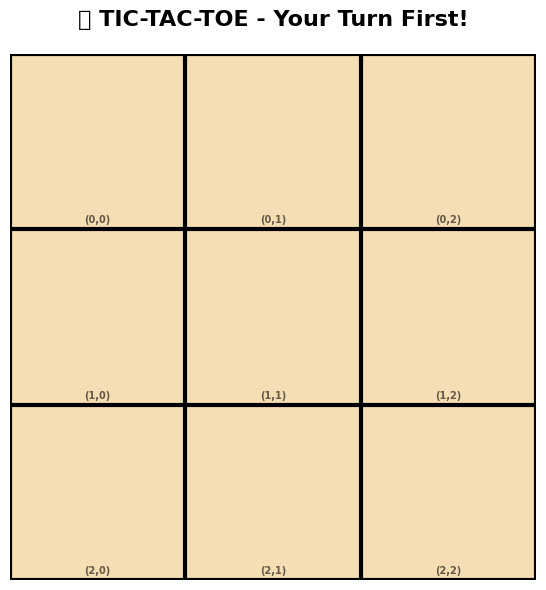

Visual Tic-Tac-Toe Board initialized successfully!

Board Layout:
- 3x3 Grid with coordinates (row,col)
- Player: X (Blue)
- Robot: O (Red)
- Click positions shown as (row,col) above each cell


In [8]:
# %% [markdown]
# ### Display Initial Board

# %%
# Create and display initial board
board = VisualTicTacToeBoard()

fig, ax = plt.subplots(figsize=(6, 6))
board.draw_board(ax)
plt.tight_layout()
plt.show()

print("Visual Tic-Tac-Toe Board initialized successfully!")
print("\nBoard Layout:")
print("- 3x3 Grid with coordinates (row,col)")
print("- Player: X (Blue)")
print("- Robot: O (Red)")
print("- Click positions shown as (row,col) above each cell")

In [9]:
# %% [markdown]
# ## Task 4: Interactive Tic-Tac-Toe Game with Enhanced Move Display

# %%
class InteractiveTicTacToe:
    """
    Interactive Tic-Tac-Toe game with enhanced move visualization
    """
    def __init__(self, train_episodes=1000):
        self.robot_agent = QLearningAgent()
        self.game = TicTacToeGame(self.robot_agent)
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.train_episodes = train_episodes
        self.stats = {
            'player_wins': 0,
            'robot_wins': 0,
            'draws': 0,
            'total_games': 0,
            'player_moves': [],
            'robot_moves': []
        }
    
    def train_robot(self, episodes=None):
        """Train the robot by self-play"""
        if episodes is None:
            episodes = self.train_episodes
        
        print(f"Training robot for {episodes} episodes...")
        
        for episode in range(episodes):
            self.game.reset()
            episode_states = []
            episode_actions = []
            move_counter = 1
            
            # Self-play
            while not self.game.game_over:
                current_state = [row[:] for row in self.game.board.board_state]
                action = self.robot_agent.choose_action(current_state, training=True)
                
                if action is None:
                    break
                
                row, col = self.robot_agent.get_pos_from_action(action)
                player = self.game.current_player
                
                # Record move with move number
                self.game.board.make_move(row, col, player, move_counter)
                move_counter += 1
                
                episode_states.append(current_state)
                episode_actions.append(action)
                
                self.game.check_game_end()
                if not self.game.game_over:
                    self.game.switch_player()
            
            # Update Q-table based on game outcome
            reward = self.robot_agent.get_reward(self.game.board, 'O')
            
            # Learn from the entire episode
            for i in range(len(episode_states)):
                if i + 1 < len(episode_states):
                    next_state = episode_states[i + 1]
                else:
                    next_state = self.game.board.board_state
                
                self.robot_agent.update_q_table(
                    episode_states[i], 
                    episode_actions[i], 
                    next_state, 
                    reward if self.game.current_player == 'O' else -reward
                )
            
            # Decay exploration rate
            self.robot_agent.decay_exploration()
            
            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{episodes}, Exploration: {self.robot_agent.exploration_rate:.3f}")
        
        print("Training completed!")
    
    def play_interactive_game(self):
        """Play an interactive game with the trained robot"""
        self.game.reset()
        self.update_display()
        
        print("\n" + "="*60)
        print("🎮 INTERACTIVE TIC-TAC-TOE GAME 🎮")
        print("="*60)
        print("You are X (Blue), Robot is O (Red)")
        print("Each move shows: Player, Position, and Move Number")
        print("Last move is highlighted with gold border 🌟")
        print("Move numbers shown in gray circles 🔘")
        print("\nEnter moves as row,col (e.g., 0,0 for top-left)")
        print("Commands: 'quit'=exit, 'reset'=new game, 'help'=show help")
        print("="*60)
        
        while True:
            if self.game.game_over:
                self.update_stats()
                self.display_stats()
                
                # Show final move summary
                print("\n" + "="*60)
                print("📋 FINAL MOVE SUMMARY:")
                print("-" * 60)
                for player, row, col, move_num in self.game.move_history:
                    player_name = "You (X)" if player == 'X' else "Robot (O)"
                    print(f"Move {move_num}: {player_name} at position ({row},{col})")
                print("="*60)
                
                choice = input("\n🎯 Game over! Play again? (y/n): ").lower()
                if choice == 'y':
                    self.game.reset()
                    self.update_display()
                    print("\n🔄 New game started! Your turn first!")
                else:
                    print("\n👋 Thanks for playing!")
                    break
            
            if self.game.current_player == 'X':
                # Player's turn
                print(f"\n📝 YOUR TURN (Move {self.game.move_counter})")
                move = input("Enter your move (row,col) or command: ").strip().lower()
                
                if move == 'quit':
                    print("👋 Thanks for playing!")
                    break
                elif move == 'reset':
                    self.game.reset()
                    self.update_display()
                    print("\n🔄 Game reset! Your turn first!")
                    continue
                elif move == 'help':
                    self.display_help()
                    continue
                elif move == 'moves':
                    self.display_move_history()
                    continue
                
                try:
                    row, col = map(int, move.split(','))
                    if self.game.player_move(row, col):
                        print(f"✅ You placed X at ({row},{col}) - Move {self.game.move_counter - 1}")
                        self.update_display()
                        if not self.game.game_over:
                            print("\n🤖 Robot is thinking...")
                            time.sleep(0.8)  # Small delay for realism
                    else:
                        print("❌ Invalid move! Position already taken or out of bounds.")
                except:
                    print("❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)")
            
            else:
                # Robot's turn
                print(f"\n🤖 ROBOT'S TURN (Move {self.game.move_counter})")
                time.sleep(0.5)  # Small delay for realism
                
                if self.game.robot_move():
                    last_move = self.game.move_history[-1]
                    row, col = last_move[1], last_move[2]
                    print(f"🤖 Robot placed O at ({row},{col}) - Move {self.game.move_counter - 1}")
                    self.update_display()
                else:
                    print("❌ Robot couldn't make a move!")
    
    def update_display(self):
        """Update the visual display"""
        self.game.board.draw_board(self.ax, self.game.winning_line)
        plt.tight_layout()
        plt.draw()
        plt.pause(0.1)
        
        # Also show text representation
        self.game.board.display_text_board()
    
    def display_help(self):
        """Display help information"""
        print("\n" + "="*60)
        print("📖 HELP & INSTRUCTIONS:")
        print("="*60)
        print("Board Positions:")
        print("(0,0) - Top-left     (0,1) - Top-center     (0,2) - Top-right")
        print("(1,0) - Middle-left  (1,1) - Center         (1,2) - Middle-right")
        print("(2,0) - Bottom-left  (2,1) - Bottom-center  (2,2) - Bottom-right")
        print("\nGame Features:")
        print("• Each move is numbered (shown in gray circles)")
        print("• Last move has gold border highlight 🌟")
        print("• Blue background = Your moves")
        print("• Pink background = Robot's moves")
        print("• Green highlight = Winning line")
        print("\nCommands: quit, reset, help, moves")
        print("="*60)
    
    def display_move_history(self):
        """Display detailed move history"""
        print("\n" + "="*60)
        print("📜 MOVE HISTORY:")
        print("="*60)
        
        if not self.game.move_history:
            print("No moves yet!")
        else:
            for player, row, col, move_num in self.game.move_history:
                player_name = "You (X)" if player == 'X' else "Robot (O)"
                position_name = self.get_position_name(row, col)
                print(f"Move {move_num:2d}: {player_name:10} at ({row},{col}) - {position_name}")
        print("="*60)
    
    def get_position_name(self, row, col):
        """Get descriptive name for position"""
        positions = {
            (0, 0): "Top-left",
            (0, 1): "Top-center",
            (0, 2): "Top-right",
            (1, 0): "Middle-left",
            (1, 1): "Center",
            (1, 2): "Middle-right",
            (2, 0): "Bottom-left",
            (2, 1): "Bottom-center",
            (2, 2): "Bottom-right"
        }
        return positions.get((row, col), f"Position ({row},{col})")
    
    def update_stats(self):
        """Update game statistics"""
        self.stats['total_games'] += 1
        if self.game.winner == 'X':
            self.stats['player_wins'] += 1
            self.stats['player_moves'].append(len([m for m in self.game.move_history if m[0] == 'X']))
        elif self.game.winner == 'O':
            self.stats['robot_wins'] += 1
            self.stats['robot_moves'].append(len([m for m in self.game.move_history if m[0] == 'O']))
        elif self.game.winner == 'draw':
            self.stats['draws'] += 1
    
    def display_stats(self):
        """Display game statistics"""
        print("\n" + "="*60)
        print("📊 GAME STATISTICS")
        print("="*60)
        print(f"Total Games: {self.stats['total_games']}")
        print(f"Your Wins: {self.stats['player_wins']}")
        print(f"Robot Wins: {self.stats['robot_wins']}")
        print(f"Draws: {self.stats['draws']}")
        
        if self.stats['total_games'] > 0:
            win_rate = self.stats['player_wins'] / self.stats['total_games'] * 100
            print(f"Your Win Rate: {win_rate:.1f}%")
        
        if self.stats['player_moves']:
            avg_moves = sum(self.stats['player_moves']) / len(self.stats['player_moves'])
            print(f"Average moves when you win: {avg_moves:.1f}")
        
        if self.game.move_history:
            total_moves = len(self.game.move_history)
            print(f"This game had {total_moves} moves")
        
        print("="*60)
    
    def save_agent(self, filename='tic_tac_toe_agent.npy'):
        """Save the trained agent"""
        self.robot_agent.save_q_table(filename)
    
    def load_agent(self, filename='tic_tac_toe_agent.npy'):
        """Load a trained agent"""
        self.robot_agent.load_q_table(filename)


🎮 Starting interactive Tic-Tac-Toe game...
Tip: Type 'help' for instructions



C:\Users\H\AppData\Local\Temp\ipykernel_12560\4204252402.py:171: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H\AppData\Local\Temp\ipykernel_12560\4204252402.py:172: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.draw()


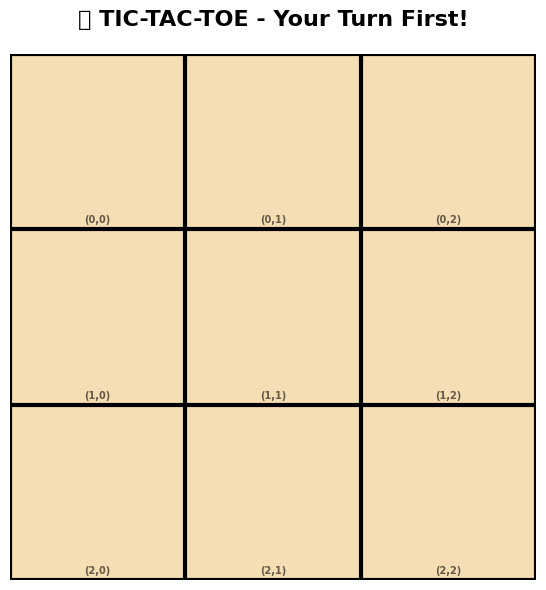


CURRENT BOARD STATE
[0,0] | [0,1] | [0,2]
--------------------
[1,0] | [1,1] | [1,2]
--------------------
[2,0] | [2,1] | [2,2]

Next: ROBOT's turn (Move 1)

🎮 INTERACTIVE TIC-TAC-TOE GAME 🎮
You are X (Blue), Robot is O (Red)
Each move shows: Player, Position, and Move Number
Last move is highlighted with gold border 🌟
Move numbers shown in gray circles 🔘

Enter moves as row,col (e.g., 0,0 for top-left)
Commands: 'quit'=exit, 'reset'=new game, 'help'=show help

📝 YOUR TURN (Move 1)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 1)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 1)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 1)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 1)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 1)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 1)
❌ Invalid input! Format: row,col

<Figure size 640x480 with 0 Axes>


CURRENT BOARD STATE
X(1) | [0,1] | [0,2]
--------------------
[1,0] | [1,1] | [1,2]
--------------------
[2,0] | [2,1] | [2,2]

MOVE HISTORY:
--------------------
Move 1: Player (X) at (0,0)

Next: PLAYER's turn (Move 2)

🤖 Robot is thinking...

🤖 ROBOT'S TURN (Move 2)
🤖 Robot placed O at (0,1) - Move 2


<Figure size 640x480 with 0 Axes>


CURRENT BOARD STATE
X(1) | O(2) | [0,2]
--------------------
[1,0] | [1,1] | [1,2]
--------------------
[2,0] | [2,1] | [2,2]

MOVE HISTORY:
--------------------
Move 1: Player (X) at (0,0)
Move 2: Robot (O) at (0,1)

Next: ROBOT's turn (Move 3)

📝 YOUR TURN (Move 3)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 3)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 3)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 3)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 3)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 3)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 3)
❌ Invalid input! Format: row,col (e.g., 0,0 for top-left)

📝 YOUR TURN (Move 3)

📜 MOVE HISTORY:
Move  1: You (X)    at (0,0) - Top-left
Move  2: Robot (O)  at (0,1) - Top-center

📝 YOUR TURN (Move 3)


In [ ]:
# %% [markdown]
# ## Play the Enhanced Tic-Tac-Toe Game

# %%
# Create interactive game with enhanced move display
game = InteractiveTicTacToe(train_episodes=3000)

# Train the robot (optional - comment out to play immediately)
# print("🤖 Training the robot...")
# game.train_robot(1000)
# print("✅ Training complete!")

# Or load a pre-trained agent (if available)
# try:
#     game.load_agent('tic_tac_toe_agent.npy')
#     print("✅ Loaded pre-trained agent!")
# except:
#     print("⚠️ No pre-trained agent found, starting fresh")

# Play interactive game
print("\n🎮 Starting interactive Tic-Tac-Toe game...")
print("Tip: Type 'help' for instructions\n")
game.play_interactive_game()

# Optionally save the trained agent
# save_choice = input("\n💾 Save the trained agent? (y/n): ").lower()
# if save_choice == 'y':
#     game.save_agent()
#     print("✅ Agent saved!")







In [ ]:
# %% [markdown]
# ## Quick Test: See the Move Indicators in Action

# %%
# Quick demonstration of move indicators
print("🎬 DEMONSTRATION: Move Indicators in Action")
print("="*50)

# Create a test game
test_board = VisualTicTacToeBoard()

# Make some test moves
test_board.make_move(0, 0, 'X', 1)  # Player move 1
test_board.make_move(1, 1, 'O', 2)  # Robot move 2
test_board.make_move(0, 2, 'X', 3)  # Player move 3
test_board.make_move(2, 2, 'O', 4)  # Robot move 4

# Display the board
fig, ax = plt.subplots(figsize=(6, 6))
test_board.draw_board(ax)
plt.tight_layout()
plt.show()

# Display text version
test_board.display_text_board()

print("\n📝 What you see:")
print("1. Each move has a number (1, 2, 3, 4)")
print("2. Last move (Robot at 2,2) has gold border")
print("3. Blue background = Your moves")
print("4. Pink background = Robot's moves")
print("5. Position labels show coordinates")
print("="*50)